<a href="https://colab.research.google.com/github/prp20/tensorflow_learning/blob/main/notebooks/nlp_practise_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds

tf.__version__

'2.9.2'

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5bfb5ce1-5e45-26c7-2f4a-0dd5d6f603d6)


In [3]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d chaitanyakck/medical-text

  0% 0.00/11.6M [00:00<?, ?B/s]
100% 11.6M/11.6M [00:00<00:00, 129MB/s]


In [8]:
! unzip medical-text.zip

Archive:  medical-text.zip
  inflating: test.dat                
  inflating: train.dat               


In [48]:
def create_text_labels(fname):
  labels = []
  texts = []
  with open(fname, "r") as fh:
    train_lines = fh.readlines() 
  for line in train_lines:
    splitline = line.split('\t')
    labels.append(int(splitline[0]))
    texts.append(splitline[1])
  return texts, labels

In [49]:
data, labels = create_text_labels("train.dat")

In [52]:
for val in range(10):
  print(data[val]+ "\t" + str(labels[val]))

Catheterization laboratory events and hospital outcome with direct angioplasty for acute myocardial infarction To assess the safety of direct infarct angioplasty without antecedent thrombolytic therapy, catheterization laboratory and hospital events were assessed in consecutively treated patients with infarctions involving the left anterior descending (n = 100 patients), right (n = 100), and circumflex (n = 50) coronary arteries. The groups of patients were similar for age (left anterior descending coronary artery, 59 years; right coronary artery, 58 years; circumflex coronary artery, 62 years), patients with multivessel disease (left anterior descending coronary artery, 55%; right coronary artery, 55%; circumflex coronary artery, 64%), and patients with initial grade 0/1 antegrade flow (left anterior descending coronary artery, 79%; right coronary artery, 84%; circumflex coronary artery, 90%). Cardiogenic shock was present in eight patients with infarction of the left anterior descend

In [53]:
len(data), len(labels)

(14438, 14438)

In [54]:
labels = np.asarray(labels).reshape(-1, 1)

In [55]:
labels

array([[4],
       [5],
       [2],
       ...,
       [1],
       [2],
       [3]])

In [56]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [57]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=42)
len(train_data), len(test_data), len(train_labels), len(test_labels)

(11550, 2888, 11550, 2888)

In [58]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [59]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels)
test_labels_one_hot = one_hot_encoder.transform(test_labels)

In [60]:
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

In [61]:
NUM_CLASSES=5

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model_0.fit(train_data, train_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [63]:
model_0_score = model_0.score(test_data, test_labels)

In [64]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {
      "accuracy": model_accuracy,
      "precision":model_precision,
      "recall": model_recall,
      "f1_score": model_f1_score
  }
  return model_results

def return_callbacks(model_name):
  callbacks_list = []
  callbacks_list.append(tf.keras.callbacks.ModelCheckpoint("saved_models/"+model_name, monitor='val_loss', save_best_only='True', verbose=1))
  callbacks_list.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights='True'))
  return callbacks_list

In [65]:
model_0_preds = model_0.predict(test_data)
model_0_results = calculate_results(test_labels, model_0_preds)
model_results_dataset = {}
model_results_dataset['model_0'] = model_0_results
model_0_results

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 49.411357340720215,
 'precision': 0.5369400656025278,
 'recall': 0.4941135734072022,
 'f1_score': 0.436777962137569}

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels_one_hot))

# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [36]:
from tensorflow.keras.layers import TextVectorization
output_seq_length = round(sum([len(i.split()) for i in train_data])/len(train_data))
tv_layer = TextVectorization(max_tokens=10000, standardize="lower_and_strip_punctuation", split="whitespace", output_mode="int", output_sequence_length=output_seq_length, pad_to_max_tokens=True)
tv_layer.adapt(train_data)

In [37]:
from tensorflow.keras import layers

embedding_layer = layers.Embedding(input_dim=10000, output_dim=128, input_length=output_seq_length)

In [38]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = tv_layer(inputs)
x = embedding_layer(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, output, name="nlp_model_1")
model_1.summary()

Model: "nlp_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 180)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 180, 128)          1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 1,280,645
Trainable params: 1,280,645
Non

In [66]:
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_1 = model_1.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=return_callbacks(model_1.name))

Epoch 1/50
352/361 [============================>.] - ETA: 0s - loss: 0.7768 - accuracy: 0.6866
Epoch 1: val_loss improved from inf to 1.00897, saving model to saved_models/nlp_model_1
361/361 [==============================] - 4s 8ms/step - loss: 0.7769 - accuracy: 0.6858 - val_loss: 1.0090 - val_accuracy: 0.5720
Epoch 2/50
361/361 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.7023
Epoch 2: val_loss did not improve from 1.00897
361/361 [==============================] - 2s 6ms/step - loss: 0.7209 - accuracy: 0.7023 - val_loss: 1.0256 - val_accuracy: 0.5689
Epoch 3/50
361/361 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.7158
Epoch 3: val_loss did not improve from 1.00897
361/361 [==============================] - 3s 8ms/step - loss: 0.6731 - accuracy: 0.7158 - val_loss: 1.0512 - val_accuracy: 0.5609
Epoch 4/50
357/361 [============================>.] - ETA: 0s - loss: 0.6304 - accuracy: 0.7293
Epoch 4: val_loss did not improve from 1

In [67]:
model_1.evaluate(test_dataset)
model_1_loaded = tf.keras.models.load_model("saved_models/nlp_model_1")
model_1_preds = model_1_loaded.predict(test_dataset)
model_1_results = calculate_results(test_labels, tf.argmax(model_1_preds, axis=1))
model_results_dataset['model_1'] = model_1_results
model_1_results

91/91 [==============================] - 0s 3ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 8.829639889196676,
 'precision': 0.06526131289348824,
 'recall': 0.08829639889196676,
 'f1_score': 0.06713543423412932}

In [41]:
tf.keras.backend.clear_session()

In [68]:
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=10000, output_dim=128, embeddings_initializer="uniform", input_length=output_seq_length, name="embedding_2")

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = tv_layer(inputs)
x = model_2_embedding(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, output, name="nlp_model_2")
model_2.summary()

Model: "nlp_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 180)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 180, 128)          1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 5)                 

In [69]:
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_2 = model_2.fit(train_dataset, epochs=20, validation_data=test_dataset,callbacks=return_callbacks(model_2.name))

Epoch 1/20
360/361 [============================>.] - ETA: 0s - loss: 1.3282 - accuracy: 0.4444
Epoch 1: val_loss improved from inf to 1.11776, saving model to saved_models/nlp_model_2
361/361 [==============================] - 4s 9ms/step - loss: 1.3276 - accuracy: 0.4448 - val_loss: 1.1178 - val_accuracy: 0.5409
Epoch 2/20
352/361 [============================>.] - ETA: 0s - loss: 0.9488 - accuracy: 0.5978
Epoch 2: val_loss improved from 1.11776 to 0.99340, saving model to saved_models/nlp_model_2
361/361 [==============================] - 4s 10ms/step - loss: 0.9465 - accuracy: 0.5984 - val_loss: 0.9934 - val_accuracy: 0.5651
Epoch 3/20
361/361 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.6766
Epoch 3: val_loss did not improve from 0.99340
361/361 [==============================] - 2s 6ms/step - loss: 0.7666 - accuracy: 0.6766 - val_loss: 1.0119 - val_accuracy: 0.5686
Epoch 4/20
359/361 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 

In [70]:
model_2.evaluate(test_dataset)
model_2_loaded = tf.keras.models.load_model("saved_models/nlp_model_2")
model_2_preds = model_2_loaded.predict(test_dataset)
model_2_results = calculate_results(test_labels, tf.argmax(model_2_preds, axis=1))
model_results_dataset['model_2'] = model_2_results
model_2_results

91/91 [==============================] - 0s 3ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 8.379501385041552,
 'precision': 0.05900035221026017,
 'recall': 0.08379501385041552,
 'f1_score': 0.06259384370506027}

In [71]:
tf.keras.backend.clear_session()

In [72]:
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=10000, output_dim=128, embeddings_initializer="uniform", input_length=output_seq_length, name="embedding_2")

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = tv_layer(inputs)
x = model_3_embedding(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, output, name="nlp_model_3")
model_3.summary()

Model: "nlp_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 180)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 180, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                       

In [73]:
model_3.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_3 = model_3.fit(train_dataset, epochs=20, validation_data=test_dataset,callbacks=return_callbacks(model_3.name))

Epoch 1/20
359/361 [============================>.] - ETA: 0s - loss: 1.4732 - accuracy: 0.3619
Epoch 1: val_loss improved from inf to 1.53226, saving model to saved_models/nlp_model_3


361/361 [==============================] - 10s 25ms/step - loss: 1.4736 - accuracy: 0.3617 - val_loss: 1.5323 - val_accuracy: 0.3466
Epoch 2/20
358/361 [============================>.] - ETA: 0s - loss: 1.3904 - accuracy: 0.3891
Epoch 2: val_loss improved from 1.53226 to 1.37303, saving model to saved_models/nlp_model_3


361/361 [==============================] - 11s 30ms/step - loss: 1.3904 - accuracy: 0.3900 - val_loss: 1.3730 - val_accuracy: 0.3885
Epoch 3/20
361/361 [==============================] - ETA: 0s - loss: 1.3081 - accuracy: 0.4341
Epoch 3: val_loss did not improve from 1.37303
361/361 [==============================] - 5s 13ms/step - loss: 1.3081 - accuracy: 0.4341 - val_loss: 1.4560 - val_accuracy: 0.3816
Epoch 4/20
359/361 [============================>.] - ETA: 0s - loss: 1.3021 - accuracy: 0.4569
Epoch 4: val_loss did not improve from 1.37303
361/361 [==============================] - 5s 13ms/step - loss: 1.3027 - accuracy: 0.4569 - val_loss: 1.4145 - val_accuracy: 0.4055
Epoch 5/20
358/361 [============================>.] - ETA: 0s - loss: 1.2686 - accuracy: 0.4768
Epoch 5: val_loss improved from 1.37303 to 1.36542, saving model to saved_models/nlp_model_3


361/361 [==============================] - 8s 23ms/step - loss: 1.2693 - accuracy: 0.4767 - val_loss: 1.3654 - val_accuracy: 0.4304
Epoch 6/20
359/361 [============================>.] - ETA: 0s - loss: 1.2227 - accuracy: 0.5008
Epoch 6: val_loss did not improve from 1.36542
361/361 [==============================] - 5s 13ms/step - loss: 1.2233 - accuracy: 0.5008 - val_loss: 1.3789 - val_accuracy: 0.4041
Epoch 7/20
357/361 [============================>.] - ETA: 0s - loss: 1.2160 - accuracy: 0.5009
Epoch 7: val_loss improved from 1.36542 to 1.32115, saving model to saved_models/nlp_model_3


361/361 [==============================] - 9s 24ms/step - loss: 1.2141 - accuracy: 0.5021 - val_loss: 1.3212 - val_accuracy: 0.4726
Epoch 8/20
357/361 [============================>.] - ETA: 0s - loss: 0.9886 - accuracy: 0.6015
Epoch 8: val_loss improved from 1.32115 to 1.23272, saving model to saved_models/nlp_model_3


361/361 [==============================] - 8s 23ms/step - loss: 0.9884 - accuracy: 0.6017 - val_loss: 1.2327 - val_accuracy: 0.5177
Epoch 9/20
359/361 [============================>.] - ETA: 0s - loss: 0.8468 - accuracy: 0.6453
Epoch 9: val_loss improved from 1.23272 to 1.19379, saving model to saved_models/nlp_model_3


361/361 [==============================] - 9s 25ms/step - loss: 0.8474 - accuracy: 0.6452 - val_loss: 1.1938 - val_accuracy: 0.5267
Epoch 10/20
360/361 [============================>.] - ETA: 0s - loss: 0.7608 - accuracy: 0.6790
Epoch 10: val_loss did not improve from 1.19379
361/361 [==============================] - 5s 13ms/step - loss: 0.7613 - accuracy: 0.6790 - val_loss: 1.2187 - val_accuracy: 0.5184
Epoch 11/20
357/361 [============================>.] - ETA: 0s - loss: 0.6960 - accuracy: 0.7032
Epoch 11: val_loss did not improve from 1.19379
361/361 [==============================] - 5s 12ms/step - loss: 0.6978 - accuracy: 0.7029 - val_loss: 1.2636 - val_accuracy: 0.5166
Epoch 12/20
361/361 [==============================] - ETA: 0s - loss: 0.6490 - accuracy: 0.7229
Epoch 12: val_loss did not improve from 1.19379
361/361 [==============================] - 5s 13ms/step - loss: 0.6490 - accuracy: 0.7229 - val_loss: 1.3613 - val_accuracy: 0.5100
Epoch 13/20
357/361 [================

In [74]:
model_3.evaluate(test_dataset)
model_3_loaded = tf.keras.models.load_model("saved_models/nlp_model_3")
model_3_preds = model_3_loaded.predict(test_dataset)
model_3_results = calculate_results(test_labels, tf.argmax(model_3_preds, axis=1))
model_results_dataset['model_3'] = model_3_results
model_3_results

91/91 [==============================] - 1s 7ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 7.375346260387812,
 'precision': 0.05157344286420999,
 'recall': 0.07375346260387812,
 'f1_score': 0.0548008170186416}

In [75]:
tf.keras.backend.clear_session()

In [76]:
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=10000, output_dim=128, embeddings_initializer="uniform", input_length=output_seq_length, name="embedding_4")

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = tv_layer(inputs)
x = model_4_embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_4 = tf.keras.Model(inputs, output, name="nlp_model_4")
model_4.summary()

Model: "nlp_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 180)              0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 180, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 180, 64)           49408     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                       

In [77]:
model_4.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_4 = model_4.fit(train_dataset, epochs=20, validation_data=test_dataset,callbacks=return_callbacks(model_4.name))
     

Epoch 1/20
359/361 [============================>.] - ETA: 0s - loss: 1.4709 - accuracy: 0.3696
Epoch 1: val_loss improved from inf to 1.42708, saving model to saved_models/nlp_model_4


361/361 [==============================] - 22s 54ms/step - loss: 1.4711 - accuracy: 0.3694 - val_loss: 1.4271 - val_accuracy: 0.4404
Epoch 2/20
361/361 [==============================] - ETA: 0s - loss: 1.3288 - accuracy: 0.4562
Epoch 2: val_loss improved from 1.42708 to 1.21964, saving model to saved_models/nlp_model_4


361/361 [==============================] - 14s 40ms/step - loss: 1.3288 - accuracy: 0.4562 - val_loss: 1.2196 - val_accuracy: 0.5312
Epoch 3/20
359/361 [============================>.] - ETA: 0s - loss: 1.1058 - accuracy: 0.5575
Epoch 3: val_loss improved from 1.21964 to 1.18270, saving model to saved_models/nlp_model_4


361/361 [==============================] - 14s 38ms/step - loss: 1.1059 - accuracy: 0.5577 - val_loss: 1.1827 - val_accuracy: 0.5540
Epoch 4/20
358/361 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5987
Epoch 4: val_loss did not improve from 1.18270
361/361 [==============================] - 8s 21ms/step - loss: 0.9882 - accuracy: 0.5987 - val_loss: 1.2018 - val_accuracy: 0.5492
Epoch 5/20
359/361 [============================>.] - ETA: 0s - loss: 0.8707 - accuracy: 0.6395
Epoch 5: val_loss improved from 1.18270 to 1.16768, saving model to saved_models/nlp_model_4


361/361 [==============================] - 16s 45ms/step - loss: 0.8715 - accuracy: 0.6395 - val_loss: 1.1677 - val_accuracy: 0.5509
Epoch 6/20
359/361 [============================>.] - ETA: 0s - loss: 0.7811 - accuracy: 0.6737
Epoch 6: val_loss did not improve from 1.16768
361/361 [==============================] - 7s 19ms/step - loss: 0.7819 - accuracy: 0.6736 - val_loss: 1.1867 - val_accuracy: 0.5429
Epoch 7/20
361/361 [==============================] - ETA: 0s - loss: 0.7216 - accuracy: 0.7007
Epoch 7: val_loss did not improve from 1.16768
361/361 [==============================] - 8s 21ms/step - loss: 0.7216 - accuracy: 0.7007 - val_loss: 1.1989 - val_accuracy: 0.5343
Epoch 8/20
359/361 [============================>.] - ETA: 0s - loss: 0.6617 - accuracy: 0.7305
Epoch 8: val_loss did not improve from 1.16768
361/361 [==============================] - 7s 21ms/step - loss: 0.6626 - accuracy: 0.7306 - val_loss: 1.2751 - val_accuracy: 0.5256
Epoch 9/20
360/361 [======================

In [78]:
model_4.evaluate(test_dataset)
model_4_loaded = tf.keras.models.load_model("saved_models/nlp_model_4")
model_4_preds = model_4_loaded.predict(test_dataset)
model_4_results = calculate_results(test_labels, tf.argmax(model_4_preds, axis=1))
model_results_dataset['model_4'] = model_4_results
model_4_results

91/91 [==============================] - 2s 9ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 8.067867036011082,
 'precision': 0.04965719983612757,
 'recall': 0.08067867036011081,
 'f1_score': 0.05773820398490547}

In [79]:
tf.keras.backend.clear_session()

In [80]:
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=10000, output_dim=128, embeddings_initializer="uniform", input_length=output_seq_length, name="embedding_5")

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = tv_layer(inputs)
x = model_5_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_5 = tf.keras.Model(inputs, output, name="nlp_model_5")
model_5.summary()

Model: "nlp_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 180)              0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 180, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 180, 128)         98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                       

In [81]:
model_5.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_5 = model_5.fit(train_dataset, epochs=20, validation_data=test_dataset,callbacks=return_callbacks(model_5.name))

Epoch 1/20
360/361 [============================>.] - ETA: 0s - loss: 1.2209 - accuracy: 0.4895
Epoch 1: val_loss improved from inf to 1.05502, saving model to saved_models/nlp_model_5


361/361 [==============================] - 39s 94ms/step - loss: 1.2207 - accuracy: 0.4899 - val_loss: 1.0550 - val_accuracy: 0.5738
Epoch 2/20
361/361 [==============================] - ETA: 0s - loss: 0.9162 - accuracy: 0.6276
Epoch 2: val_loss did not improve from 1.05502
361/361 [==============================] - 13s 35ms/step - loss: 0.9162 - accuracy: 0.6276 - val_loss: 1.0666 - val_accuracy: 0.5699
Epoch 3/20
361/361 [==============================] - ETA: 0s - loss: 0.7665 - accuracy: 0.6944
Epoch 3: val_loss did not improve from 1.05502
361/361 [==============================] - 12s 34ms/step - loss: 0.7665 - accuracy: 0.6944 - val_loss: 1.1442 - val_accuracy: 0.5606
Epoch 4/20
361/361 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.7268
Epoch 4: val_loss did not improve from 1.05502
361/361 [==============================] - 12s 33ms/step - loss: 0.6779 - accuracy: 0.7268 - val_loss: 1.2066 - val_accuracy: 0.5488
Epoch 5/20
361/361 [===================

In [82]:
model_5.evaluate(test_dataset)
model_5_loaded = tf.keras.models.load_model("saved_models/nlp_model_5")
model_5_preds = model_5_loaded.predict(test_dataset)
model_5_results = calculate_results(test_labels, tf.argmax(model_5_preds, axis=1))
model_results_dataset['model_5'] = model_5_results
model_5_results

91/91 [==============================] - 2s 15ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 6.752077562326869,
 'precision': 0.05384783151965126,
 'recall': 0.06752077562326869,
 'f1_score': 0.049941019941433795}

In [83]:
tf.keras.backend.clear_session()

model_6_embedding = layers.Embedding(input_dim=10000, output_dim=128, embeddings_initializer="uniform", input_length=output_seq_length, name="embedding_6")

# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = tv_layer(inputs) # vectorize text inputs
token_embeddings = model_6_embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_6 = tf.keras.Model(inputs, outputs, name="nlp_model_6")

# Compile
model_6.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_6 = model_6.fit(train_dataset, epochs=20, validation_data=test_dataset,callbacks=return_callbacks(model_6.name))

Epoch 1/20
358/361 [============================>.] - ETA: 0s - loss: 1.2530 - accuracy: 0.4787
Epoch 1: val_loss improved from inf to 1.06569, saving model to saved_models/nlp_model_6


361/361 [==============================] - 8s 10ms/step - loss: 1.2517 - accuracy: 0.4790 - val_loss: 1.0657 - val_accuracy: 0.5308
Epoch 2/20
360/361 [============================>.] - ETA: 0s - loss: 0.8829 - accuracy: 0.6273
Epoch 2: val_loss improved from 1.06569 to 1.04618, saving model to saved_models/nlp_model_6


361/361 [==============================] - 3s 9ms/step - loss: 0.8829 - accuracy: 0.6272 - val_loss: 1.0462 - val_accuracy: 0.5530
Epoch 3/20
355/361 [============================>.] - ETA: 0s - loss: 0.7228 - accuracy: 0.6863
Epoch 3: val_loss did not improve from 1.04618
361/361 [==============================] - 3s 7ms/step - loss: 0.7235 - accuracy: 0.6855 - val_loss: 1.1438 - val_accuracy: 0.5287
Epoch 4/20
355/361 [============================>.] - ETA: 0s - loss: 0.6315 - accuracy: 0.7064
Epoch 4: val_loss did not improve from 1.04618
361/361 [==============================] - 2s 7ms/step - loss: 0.6327 - accuracy: 0.7057 - val_loss: 1.2646 - val_accuracy: 0.5066
Epoch 5/20
352/361 [============================>.] - ETA: 0s - loss: 0.5752 - accuracy: 0.7139
Epoch 5: val_loss did not improve from 1.04618
361/361 [==============================] - 2s 7ms/step - loss: 0.5768 - accuracy: 0.7126 - val_loss: 1.3758 - val_accuracy: 0.4927
Epoch 6/20
361/361 [===========================

In [84]:
model_6.evaluate(test_dataset)
model_6_loaded = tf.keras.models.load_model("saved_models/nlp_model_6")
model_6_preds = model_6_loaded.predict(test_dataset)
model_6_results = calculate_results(test_labels, tf.argmax(model_6_preds, axis=1))
model_results_dataset['model_6'] = model_6_results
model_6_results

91/91 [==============================] - 0s 3ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 9.764542936288088,
 'precision': 0.06707984082798316,
 'recall': 0.09764542936288088,
 'f1_score': 0.07142276020748689}

In [85]:
tf.keras.backend.clear_session()

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

model_7 = tf.keras.Sequential([
  layers.Input(shape=[], dtype=tf.string),
  tf_hub_embedding_layer, # take in sentences and then encode them into an embedding
  layers.Dense(128, activation="relu"),
  layers.Dense(NUM_CLASSES, activation="softmax")
], name="nlp_model_7")

model_7.summary()

model_7.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_7 = model_7.fit(train_dataset, epochs=20, validation_data=test_dataset,callbacks=return_callbacks(model_7.name))

Model: "nlp_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________
Epoch 1/20
361/361 [==============================] - ETA: 0s - loss: 1.1180 - accuracy: 0.5399
Epoch 1: val_loss improved from inf to 1.01256, saving model to saved_models/nlp_model_7
361/361 [==============================] - 24s 56

In [86]:
model_7.evaluate(test_dataset)
model_7_loaded = tf.keras.models.load_model("saved_models/nlp_model_7")
model_7_preds = model_7_loaded.predict(test_dataset)
model_7_results = calculate_results(test_labels, tf.argmax(model_7_preds, axis=1))
model_results_dataset['model_7'] = model_7_results
model_7_results

91/91 [==============================] - 2s 21ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 7.756232686980609,
 'precision': 0.05633940023524356,
 'recall': 0.07756232686980609,
 'f1_score': 0.06001645960179962}

In [87]:
tf.keras.backend.clear_session()

In [88]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_data]
test_chars = [split_chars(sentence) for sentence in test_data]
print(train_chars[0])
char_lens = [len(sentence) for sentence in train_data]
mean_char_len = np.mean(char_lens)
mean_char_len
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

T h e   u n i q u e   a s p e c t s   o f   a c u t e   p r o m y e l o c y t i c   l e u k e m i a .   A c u t e   p r o m y e l o c y t i c   l e u k e m i a   ( A P L )   a c c o u n t s   f o r   a p p r o x i m a t e l y   1 0 %   o f   c a s e s   o f   a c u t e   m y e l o i d   l e u k e m i a   ( A M L ) .   D i s t i n c t i v e   f e a t u r e s   o f   t h i s   d i s o r d e r   a t   t h e   t i m e   o f   d i a g n o s i s   i n c l u d e   l e u k o p e n i a   c o e x i s t i n g   w i t h   a   m a r r o w   r e p l a c e d   w i t h   g r a n u l a t e d   d y s p l a s t i c   p r o m y e l o c y t e s ,   d i s s e m i n a t e d   i n t r a v a s c u l a r   c o a g u l o p a t h y ,   l a c k   o f   I a   ( H L A - D R )   a n t i g e n   e x p r e s s i o n ,   a n d   t r a n s l o c a t i o n   b e t w e e n   t h e   l o n g   a r m s   o f   c h r o m o s o m e s   1 5   a n d   1 7   ( t [ 1 5 ; 1 7 ] ) .   H e p a r i n   i s   w i d e l y   b u t   n o 

2054

In [89]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [90]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [91]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [92]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_8 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="nlp_model_8")

# Compile model
model_8.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [93]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [94]:
history_8 = model_8.fit(train_char_dataset, epochs=20, validation_data=val_char_dataset,callbacks=return_callbacks(model_8.name))

Epoch 1/20
359/361 [============================>.] - ETA: 0s - loss: 1.4702 - accuracy: 0.3716
Epoch 1: val_loss improved from inf to 1.34008, saving model to saved_models/nlp_model_8


361/361 [==============================] - 6s 15ms/step - loss: 1.4699 - accuracy: 0.3720 - val_loss: 1.3401 - val_accuracy: 0.4605
Epoch 2/20
360/361 [============================>.] - ETA: 0s - loss: 1.2294 - accuracy: 0.5047
Epoch 2: val_loss improved from 1.34008 to 1.18783, saving model to saved_models/nlp_model_8


361/361 [==============================] - 7s 18ms/step - loss: 1.2292 - accuracy: 0.5045 - val_loss: 1.1878 - val_accuracy: 0.5253
Epoch 3/20
357/361 [============================>.] - ETA: 0s - loss: 1.1435 - accuracy: 0.5299
Epoch 3: val_loss improved from 1.18783 to 1.14462, saving model to saved_models/nlp_model_8


361/361 [==============================] - 6s 16ms/step - loss: 1.1438 - accuracy: 0.5293 - val_loss: 1.1446 - val_accuracy: 0.5367
Epoch 4/20
357/361 [============================>.] - ETA: 0s - loss: 1.0992 - accuracy: 0.5461
Epoch 4: val_loss improved from 1.14462 to 1.11851, saving model to saved_models/nlp_model_8


361/361 [==============================] - 5s 14ms/step - loss: 1.0996 - accuracy: 0.5456 - val_loss: 1.1185 - val_accuracy: 0.5443
Epoch 5/20
361/361 [==============================] - ETA: 0s - loss: 1.0669 - accuracy: 0.5597
Epoch 5: val_loss improved from 1.11851 to 1.09924, saving model to saved_models/nlp_model_8


361/361 [==============================] - 5s 15ms/step - loss: 1.0669 - accuracy: 0.5597 - val_loss: 1.0992 - val_accuracy: 0.5523
Epoch 6/20
358/361 [============================>.] - ETA: 0s - loss: 1.0396 - accuracy: 0.5704
Epoch 6: val_loss improved from 1.09924 to 1.08501, saving model to saved_models/nlp_model_8


361/361 [==============================] - 6s 15ms/step - loss: 1.0400 - accuracy: 0.5706 - val_loss: 1.0850 - val_accuracy: 0.5575
Epoch 7/20
360/361 [============================>.] - ETA: 0s - loss: 1.0171 - accuracy: 0.5791
Epoch 7: val_loss improved from 1.08501 to 1.07601, saving model to saved_models/nlp_model_8


361/361 [==============================] - 5s 15ms/step - loss: 1.0172 - accuracy: 0.5793 - val_loss: 1.0760 - val_accuracy: 0.5575
Epoch 8/20
361/361 [==============================] - ETA: 0s - loss: 0.9991 - accuracy: 0.5880
Epoch 8: val_loss improved from 1.07601 to 1.07053, saving model to saved_models/nlp_model_8


361/361 [==============================] - 6s 15ms/step - loss: 0.9991 - accuracy: 0.5880 - val_loss: 1.0705 - val_accuracy: 0.5630
Epoch 9/20
356/361 [============================>.] - ETA: 0s - loss: 0.9838 - accuracy: 0.5954
Epoch 9: val_loss improved from 1.07053 to 1.06644, saving model to saved_models/nlp_model_8


361/361 [==============================] - 5s 14ms/step - loss: 0.9844 - accuracy: 0.5952 - val_loss: 1.0664 - val_accuracy: 0.5689
Epoch 10/20
359/361 [============================>.] - ETA: 0s - loss: 0.9720 - accuracy: 0.5994
Epoch 10: val_loss improved from 1.06644 to 1.06516, saving model to saved_models/nlp_model_8


361/361 [==============================] - 6s 16ms/step - loss: 0.9721 - accuracy: 0.5996 - val_loss: 1.0652 - val_accuracy: 0.5654
Epoch 11/20
356/361 [============================>.] - ETA: 0s - loss: 0.9604 - accuracy: 0.6058
Epoch 11: val_loss improved from 1.06516 to 1.06448, saving model to saved_models/nlp_model_8


361/361 [==============================] - 7s 19ms/step - loss: 0.9609 - accuracy: 0.6055 - val_loss: 1.0645 - val_accuracy: 0.5627
Epoch 12/20
358/361 [============================>.] - ETA: 0s - loss: 0.9508 - accuracy: 0.6114
Epoch 12: val_loss improved from 1.06448 to 1.06390, saving model to saved_models/nlp_model_8


361/361 [==============================] - 5s 14ms/step - loss: 0.9512 - accuracy: 0.6113 - val_loss: 1.0639 - val_accuracy: 0.5613
Epoch 13/20
359/361 [============================>.] - ETA: 0s - loss: 0.9422 - accuracy: 0.6147
Epoch 13: val_loss did not improve from 1.06390
361/361 [==============================] - 5s 14ms/step - loss: 0.9423 - accuracy: 0.6152 - val_loss: 1.0647 - val_accuracy: 0.5606
Epoch 14/20
357/361 [============================>.] - ETA: 0s - loss: 0.9339 - accuracy: 0.6168
Epoch 14: val_loss did not improve from 1.06390
361/361 [==============================] - 4s 12ms/step - loss: 0.9345 - accuracy: 0.6165 - val_loss: 1.0652 - val_accuracy: 0.5613
Epoch 15/20
359/361 [============================>.] - ETA: 0s - loss: 0.9273 - accuracy: 0.6185
Epoch 15: val_loss did not improve from 1.06390
361/361 [==============================] - 5s 14ms/step - loss: 0.9274 - accuracy: 0.6188 - val_loss: 1.0659 - val_accuracy: 0.5602
Epoch 16/20
361/361 [================

In [95]:
model_8.evaluate(test_dataset)
model_8_loaded = tf.keras.models.load_model("saved_models/nlp_model_8")
model_8_preds = model_8_loaded.predict(test_dataset)
model_8_results = calculate_results(test_labels, tf.argmax(model_8_preds, axis=1))
model_results_dataset['model_8'] = model_8_results
model_8_results

91/91 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 4.639889196675901,
 'precision': 0.12761786821178037,
 'recall': 0.046398891966759004,
 'f1_score': 0.0670086467498325}

In [96]:
tf.keras.backend.clear_session()

In [97]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(4, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_9 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="nlp_model_9")

In [98]:
# Compile token char model
model_9.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [99]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_data, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((test_data, test_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [100]:
history_9 = model_9.fit(train_char_token_dataset, epochs=20, validation_data=val_char_token_dataset, callbacks=return_callbacks(model_9.name))

Epoch 1/20


ValueError: ignored

In [101]:
tf.keras.backend.clear_session()

In [102]:
model_10_embedding = tf.keras.layers.Embedding(input_dim=10000, output_dim=128, embeddings_initializer="uniform", input_length=output_seq_length, name="embedding_6")

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = tv_layer(inputs)
x = model_10_embedding(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_10 = tf.keras.Model(inputs, preds, name="nlp_model_10")
model_10.summary()

Model: "nlp_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 180)              0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, 180, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 176, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 35, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 128)          

In [103]:
model_10.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_10 = model_10.fit(train_dataset, epochs=20, validation_data=test_dataset,callbacks=return_callbacks(model_10.name))

Epoch 1/20
361/361 [==============================] - ETA: 0s - loss: 1.3993 - accuracy: 0.3961
Epoch 1: val_loss improved from inf to 1.17510, saving model to saved_models/nlp_model_10


361/361 [==============================] - 6s 13ms/step - loss: 1.3993 - accuracy: 0.3961 - val_loss: 1.1751 - val_accuracy: 0.5433
Epoch 2/20
355/361 [============================>.] - ETA: 0s - loss: 1.0914 - accuracy: 0.5596
Epoch 2: val_loss improved from 1.17510 to 1.08626, saving model to saved_models/nlp_model_10


361/361 [==============================] - 4s 12ms/step - loss: 1.0906 - accuracy: 0.5601 - val_loss: 1.0863 - val_accuracy: 0.5727
Epoch 3/20
359/361 [============================>.] - ETA: 0s - loss: 0.9135 - accuracy: 0.6254
Epoch 3: val_loss did not improve from 1.08626
361/361 [==============================] - 3s 8ms/step - loss: 0.9126 - accuracy: 0.6256 - val_loss: 1.0887 - val_accuracy: 0.5976
Epoch 4/20
355/361 [============================>.] - ETA: 0s - loss: 0.7637 - accuracy: 0.6859
Epoch 4: val_loss did not improve from 1.08626
361/361 [==============================] - 3s 8ms/step - loss: 0.7627 - accuracy: 0.6868 - val_loss: 1.3499 - val_accuracy: 0.5772
Epoch 5/20
361/361 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.7129
Epoch 5: val_loss did not improve from 1.08626
361/361 [==============================] - 3s 8ms/step - loss: 0.6927 - accuracy: 0.7129 - val_loss: 1.7989 - val_accuracy: 0.5557
Epoch 6/20
357/361 [==========================

In [104]:
model_10.evaluate(test_dataset)
model_10_loaded = tf.keras.models.load_model("saved_models/nlp_model_10")
model_10_preds = model_10_loaded.predict(test_dataset)
model_10_results = calculate_results(test_labels, tf.argmax(model_10_preds, axis=1))
model_results_dataset['model_10'] = model_10_results

91/91 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
dataframe = pd.DataFrame(model_results_dataset).T
dataframe['accuracy'] = dataframe['accuracy'].div(100)
dataframe

,accuracy,precision,recall,f1_score
model_0,0.494114,0.536940,0.494114,0.436778
model_1,0.088296,0.065261,0.088296,0.067135
model_2,0.083795,0.059000,0.083795,0.062594
model_3,0.073753,0.051573,0.073753,0.054801
model_4,0.080679,0.049657,0.080679,0.057738
model_5,0.067521,0.053848,0.067521,0.049941
model_6,0.097645,0.067080,0.097645,0.071423
model_7,0.077562,0.056339,0.077562,0.060016
model_8,0.046399,0.127618,0.046399,0.067009
model_10,0.052632,0.053047,0.052632,0.040200


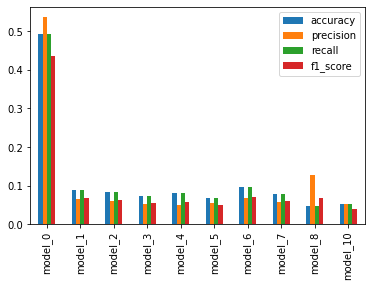

In [106]:
dataframe.plot.bar()